In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline

# ResNet Model

In [3]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [5]:
# defining ResNet with 50 layers
def ResNet50(num_classes, channels=3):
    return ResNet(block, [3,4,6,3], 3, 2)

# defining ResNet with 18 layers
def ResNet18(num_classes, channels=3):
    return ResNet(block, [2,3,2,2], 3, 2)

# Load Data and call functions

In [6]:
def get_bar_chart(data_loader):
  num = 0
  for X, y in data_loader:

    # torch.no_grad() tells PyTorch to not calculate gradients to save space
    with torch.no_grad():
      X = X.to('cpu')
      X = X.reshape(1, 3, 128, 128)
      pred_fresh  = model(X)
      dist = torch.softmax(pred_fresh, -1)
      X = X.reshape(3, 128, 128)

      fresh = round(float(dist[0][0] / (dist[0][0] + dist[0][1]) * 100))
      rotten = round(float(dist[0][1] / (dist[0][0] + dist[0][1]) * 100))

      labels = ["Fresh", "Rotten"]
      values = [fresh, rotten]


      colors = ["#9ebc8a", "#d75555"]
      fig = plt.figure(figsize=(5, 3), tight_layout=True)
      (ax1, ax2) = fig.subplots(nrows=1, ncols=2)

      # creating the bar plot
      ax1.get_xaxis().set_visible(False)
      ax1.get_yaxis().set_visible(False)
      ax1.spines['top'].set_visible(False)
      ax1.spines['right'].set_visible(False)
      ax1.spines['left'].set_visible(False)
      ax1.spines['bottom'].set_visible(False)
      ax1.imshow(X.permute(1,2,0), aspect='auto')

      ax2.bar(labels, values, color = colors, width = 0.3, align='center')
      ax2.set_ylim(0,100)
      for i in range(len(labels)):
        plt.text(i,values[i]+2,str(values[i])+"%", horizontalalignment='center', fontfamily="monospace", fontweight=3, color="#a5785f")

      ax2.spines['top'].set_visible(False)
      ax2.spines['right'].set_visible(False)
      ax2.spines['left'].set_visible(False)
      ax2.spines['bottom'].set_color('#DDDDDD')

      ax2.tick_params(axis='x')
      ax2.tick_params(axis='y')
      ax2.set_xlabel("Freshness Category")
      ax2.set_ylabel("Model Confidence (%)")
      plt.subplots_adjust(bottom=0, right=0.5, top=1, left=0.1)
      plt.savefig("/content/drive/Shareddrives/RotNotCrew/barCharts/binary/chart-"+str(num)+".jpg", transparent = True)
      num += 1


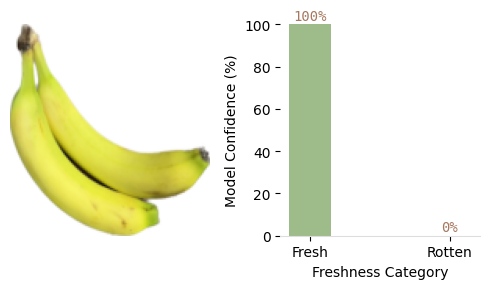

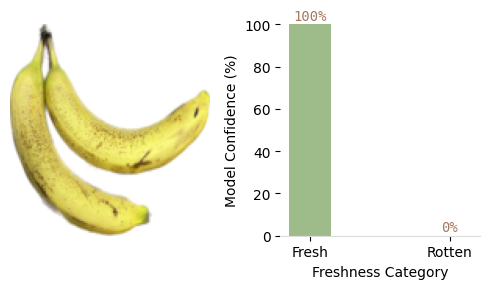

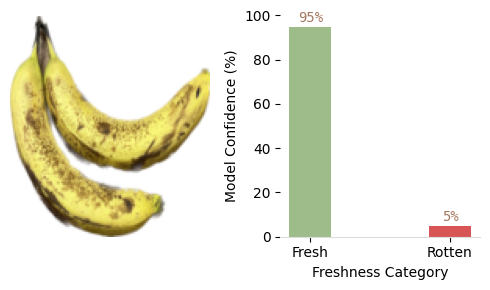

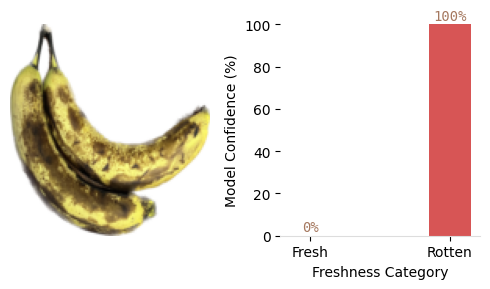

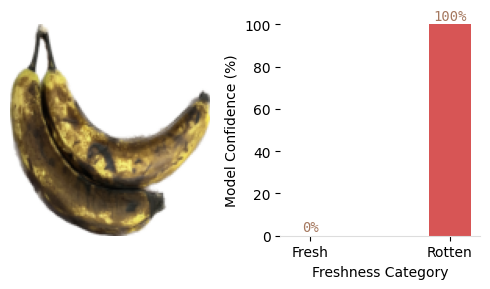

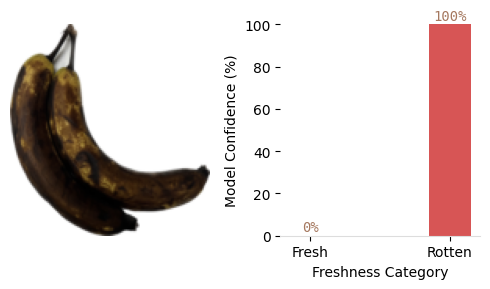

In [7]:
# global variables
seed = 0
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResNet50(2)
model.load_state_dict(torch.load("/content/drive/Shareddrives/RotNotCrew/models/ResNet50-v5-Banana.pth", map_location=torch.device('cpu')))
model.eval()

# global variables
seed = 0
device = "cuda" if torch.cuda.is_available() else "cpu"

data_dir = "/content/drive/Shareddrives/RotNotCrew/testDataset"
items = ["visualize"]
dataset = []

for item in os.listdir(data_dir):
  if item in items:
    item_dir = os.path.join(data_dir, item)
    # load the images with labels
    item_dataset = ImageFolder(item_dir, transform=transforms.Compose([transforms.Resize([128,128]),transforms.ToTensor()]))
    if len(dataset) == 0:
      dataset = item_dataset

test_loader = DataLoader(dataset,batch_size=1,shuffle=False)
get_bar_chart(test_loader)